# Using the COGITATE iEEG data 
In this notebook, we will demonstrate how to perform simple basic operation on the iEEG data of the COGITATE consortium. 
This includes applying our preprocessing pipelines to generate epoched data, as well as simple analysis such as onset 
responsiveness and decoding. 


In [3]:
# Setting all modules:
from pathlib import Path
import scipy
import mne
from mne_bids import BIDSPath, read_raw_bids
import numpy as np
import matplotlib.pyplot as plt

from pipelines.Preprocessing import preprocessing
from pipelines.OnsetResponsiveness import onset_responsiveness
from pipelines.Decoding import decoding
from HelperFunctions import get_roi_channels

## Downloading the BIDS converted data
The first step consists in downloading the data using rest API calls. The interface with XNAT enables filtering of participants,
enabling you to select subjects according to various criterion such as age, gender and various other demographic information. 
For the current example we will simply show you how to download XXXX

In [4]:
bids_root = "C://Users//alexander.lepauvre//Documents//GitHub//iEEG-data-release//bids"

The data follow the bids conventions. The mne-bids functions can therefore be used to generate path to the data and so on. 
So for example, if we wish to load the raw data, this can be achieved like so:

In [5]:
bids_path = BIDSPath(root=bids_root, subject='SF102',
                     session='V1',
                     datatype='ieeg',
                     task='Dur')
# Loading the data under the term broadband, as it is what they are as long as no further
# filtering was employed
raw = read_raw_bids(bids_path=bids_path, verbose=True)

Extracting parameters from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_events.tsv.
Reading channel info from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_channels.tsv.


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_24076\2058158197.py:7: RuntimeWarning: participants.tsv file not found for C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr
  raw = read_raw_bids(bids_path=bids_path, verbose=True)


Effective window size : 1.000 (s)


C:\Users\alexander.lepauvre\.conda\envs\mne\Lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


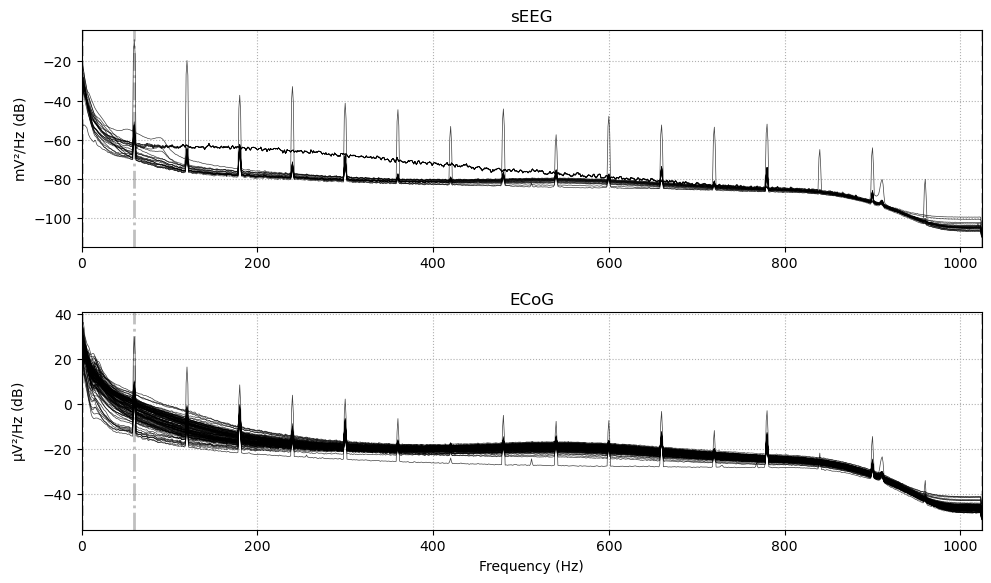

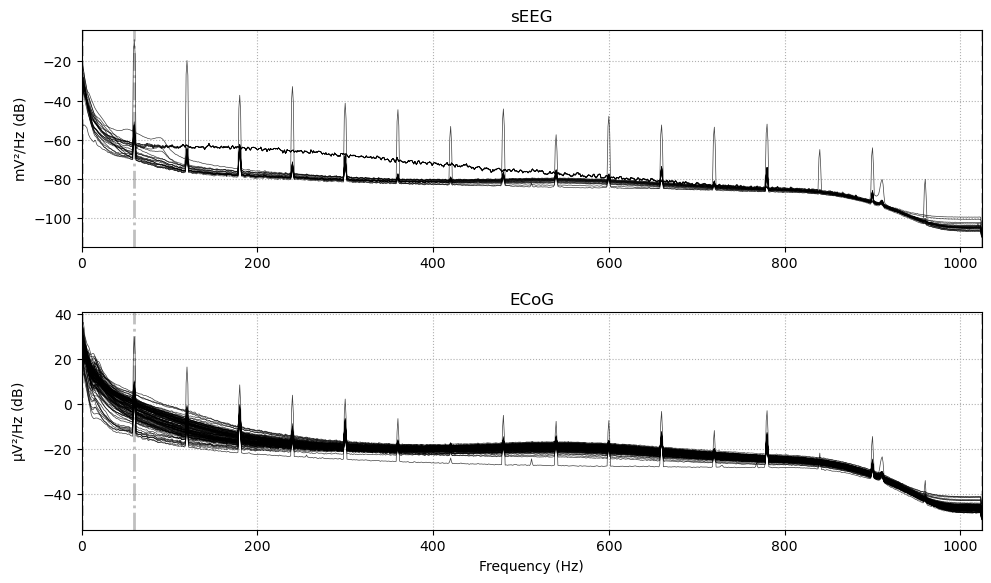

In [6]:
raw.compute_psd().plot(picks='data', exclude='bads', spatial_colors=False)

## Running the preprocessing
The BIDS downloaded data can then be preprocessed. In this code, we provide a preprocessing pipeline which applies the following
steps:
- Removal of bad channels 
- Notch filtering to remove line noise (60Hz)
- Re-referencing using Laplace scheme
- High gamma computations (70-150Hz)
- ERP computations (0-30Hz)
- Epoching
(See here for more details)

This preprocessing pipeline can be called using the provided function called preprocessing. This function requires 3 inputs:
- config_file: a json file specifying all the details of the steps to perform
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.

The command below will apply the preprocessing pipeline as specified in the default config file of this repository, which follow
the specification of this paper. The pipeline is highly configurable and can be adjusted by specifying different options,
different order of steps and so on. If you wish to change the pipeline, we recommand you create a copy of the existing one
and rename it according to your needs.

In [40]:
subjects_list = ["SF102"]
config_file = "pipelines/preprocessing_config-default.json"
preprocessing(config_file, subjects_list, bids_root)

----------------------------------------
Welcome to preprocessing!
The following subjects will now be preprocessed: 
['SF102']
Using the config file:
PreprocessingParameters_task-Duration_release.json
It may take some time, count roughly 5-10min per subject!
----------------------------------------
Preprocessing SF102 with config file PreprocessingParameters_task-Duration_release.json
Extracting parameters from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_events.tsv.
Reading channel info from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_channels.tsv.
Reading 0 ... 5060607  =      0.000 ...  2471.000 secs...


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\PreprocessingMaster.py:86: RuntimeWarning: participants.tsv file not found for C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr
  raw = {"broadband": read_raw_bids(bids_path=bids_path, verbose=True)}
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:73: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_data.set_montage(montage, on_missing='warn')
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:73: RuntimeWarning: Not setting positions of 2 ecg channels found in montage:
['EKG1', 'EKG2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  mne_data.set_montage(montage, on_missing='warn')


Downsampling the signal to 512Hz, this may take a little while
<Info | 11 non-empty values
 bads: []
 ch_names: G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, G11, G12, G13, G14, ...
 chs: 110 ECoG, 24 sEEG, 2 ECG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 134 items (134 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2015-10-09 16:59:59 UTC
 nchan: 136
 projs: []
 sfreq: 512.0 Hz
>
Detrending the data
Creating annotations
Used Annotations descriptions: ['jitter onset/block_1/miniblock_1/face/face_04/Right/1500ms/Irrelevant/n.a.', 'jitter onset/block_1/miniblock_1/face/face_07/Center/1000ms/Irrelevant/n.a.', 'jitter onset/block_1/miniblock_1/face/face_09/Center/1000ms/Irrelevant/n.a.', 'jitter onset/block_1/miniblock_1/face/face_09/Center/500ms/Irrelevant/n.a.', 'jitter onset/block_1/miniblock_1/face/face_11/Left/500ms/Irrelevant/n.a.', 'jitter onset/block_1/miniblock_1/face/f

------------------------------------------------------------
Performing description_bad_channels_rejection
Saving mne object
Overwriting existing file.
Writing C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\description_bad_channels_rejection\broadband\sub-SF102_ses-V1_task-Dur_desc-description_bad_channels_rejection_ieeg-raw.fif
Closing C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\description_bad_channels_rejection\broadband\sub-SF102_ses-V1_task-Dur_desc-description_bad_channels_rejection_ieeg-raw.fif
[done]
------------------------------------------------------------
Performing notch_filtering
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G8
Relocating channel G9


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G16
Relocating channel G17


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G24
Relocating channel G25


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G32
Relocating channel G39
Relocating channel G40


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G47
Relocating channel G48
Relocating channel G51


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G56
Relocating channel G57


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel G64
Relocating channel LOF1
Relocating channel LOF2
Relocating channel LF1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel LF6
Relocating channel LPF2


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel LPF6
Relocating channel LP1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel LP6
Relocating channel LPO1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel LPO8
Relocating channel LO1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel LO8
Relocating channel DLAMT1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Relocating channel DLAMT4
Relocating channel DLPMT1
Relocating channel DLPMT2


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1291: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Saving mne object
Overwriting existing file.
Writing C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\laplace_reference\broadband\sub-SF102_ses-V1_task-Dur_desc-laplace_reference_ieeg-raw.fif


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1200: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Closing C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\laplace_reference\broadband\sub-SF102_ses-V1_task-Dur_desc-laplace_reference_ieeg-raw.fif
[done]
------------------------------------------------------------
Performing atlas_mapping


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed 

C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df[parcellation] = labels_df[parcellation].append(
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:958: FutureWarning: The frame.append method is deprecated and will be removed 

[]
------------------------------------------------------------
Performing hg_computations
----------------------------------------
Welcome to frequency bands computation
1

----------------------------------------
Computing the frequency in band: [70, 80]
Computing the envelope amplitude
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 70 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.00
- Lower transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 97 samples (0.189 s)

Divide by average
Dividing channels amplitude by average amplitude

----------------------------------------
Computing the frequency in band: [80,

[done]
------------------------------------------------------------
Performing epoching
broadband
Performing epoching
Using data from preloaded Raw for 1440 events and 1793 original time points ...
0 bad epochs dropped
Adding metadata with 9 columns
Saving mne object
Overwriting existing file.
Using data from preloaded Raw for 1 events and 1793 original time points ...
Using data from preloaded Raw for 1440 events and 1793 original time points ...
high_gamma
Performing epoching
Using data from preloaded Raw for 1440 events and 1665 original time points ...
0 bad epochs dropped
Adding metadata with 9 columns
Saving mne object
Overwriting existing file.
Using data from preloaded Raw for 1 events and 1665 original time points ...
Using data from preloaded Raw for 1440 events and 1665 original time points ...
erp
Performing epoching
Using data from preloaded Raw for 1440 events and 1665 original time points ...
0 bad epochs dropped
Adding metadata with 9 columns
Saving mne object
Overwriti

### Visualizing the preprocessed data
The final output of the preprocessing pipeline are the epoched data. The naming conventions of the folders follow the BIDS conventions
You can therefore load the data as follows, and plot a single channel using mne functionalities

Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

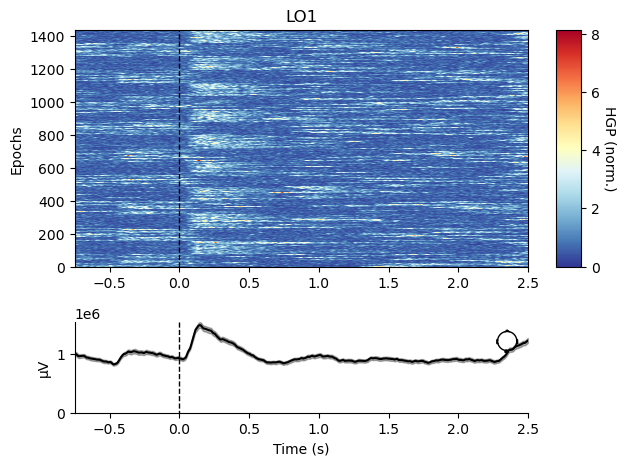

In [41]:
subject = 'SF102'
channel = 'LO1'
example_epochs_path = Path(bids_root, 'derivatives', 'preprocessing',
                           'sub-' + subject, 'ses-' + "V1", 'ieeg',
                           "epoching", 'high_gamma',
                           "sub-{}_ses-{}_task-{}_desc-epoching_{}-epo.fif".format(subject,
                                                                                   "V1", "Dur",
                                                                                   "ieeg"))

epochs = mne.read_epochs(example_epochs_path, preload=True)
mne.viz.plot_epochs_image(epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

Notice that the figure above looks odd, with some activation in the baseline. That is because we have data that are epochs relative to both the onset and the offset of the stimuli for different analyses. For most purpose, we would need to select only the epochs locked to stimulus onset. This can be achieved by selecting the epochs by conditions, like so:

Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

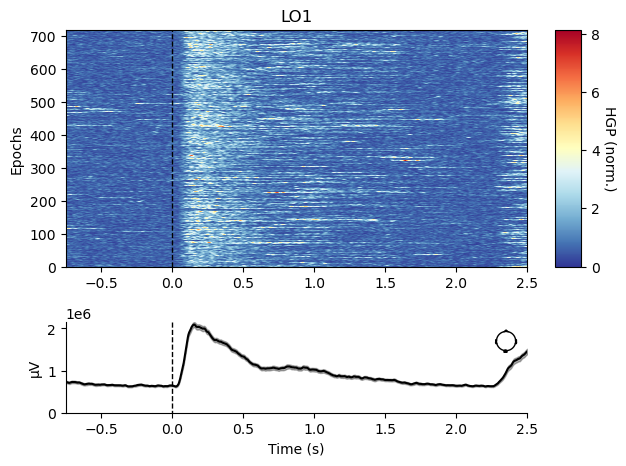

In [42]:
onset_locked_epochs = epochs['stimulus onset']
mne.viz.plot_epochs_image(onset_locked_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

In general, if you wish to extract specific conditions, this data are equipped with forward slash separated strings, enabling you to select any condition by passing the according string or list of strings. Consult the documentation found XXX to find all the conditions
that can be accessed from the data.

Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

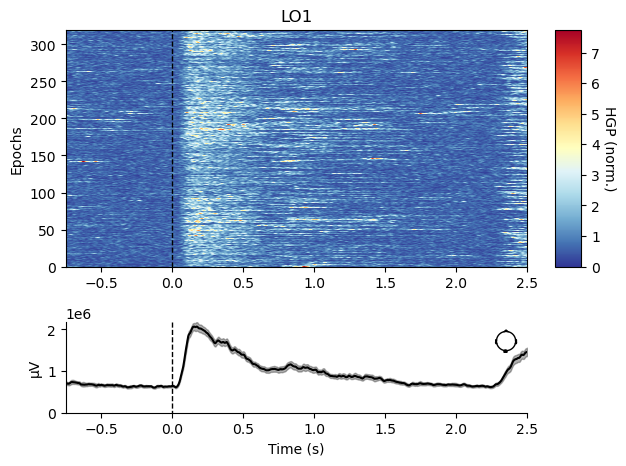

In [43]:
task_relevant_epochs = epochs['stimulus onset/Relevant non-target']
mne.viz.plot_epochs_image(task_relevant_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

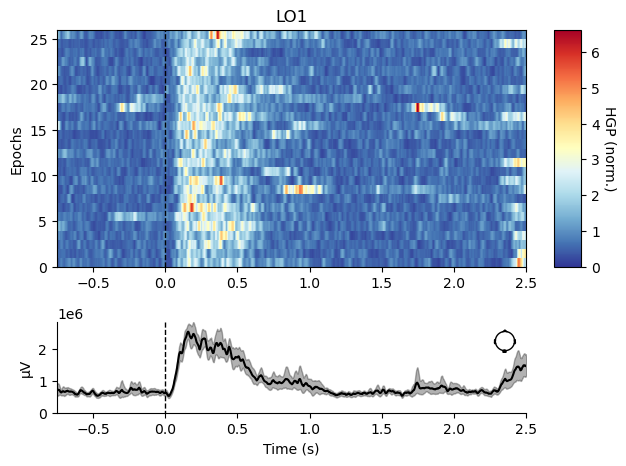

In [44]:
task_relevant_face_short_epochs = epochs['stimulus onset/Relevant non-target/face/500ms']
mne.viz.plot_epochs_image(task_relevant_face_short_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

## Onset responsiveness
Now that the data were preprocessed, we can apply the onset responsiveness analysis, which consists in comparing single channel activation before and after visual stimuli onsets, using a simple paired t-test. This enables determining which 
are the channels which are responsive to our task in general. 

To do so, we first extract the trials which are locked on the onset and on the offset and further removing the target trials, which required a response from the participants. We will then extract pre and post-stimulus presentation segments. The data within each segment will be aggregated by computing the area under the curve (np.trapz) which will then be statistically compared using a paired t-test.

T-test results:
   T-stat=-59.85820987104858
   p-value=3.4578873186477887e-264
   df=639


Text(0, 0.5, 'AUC difference')

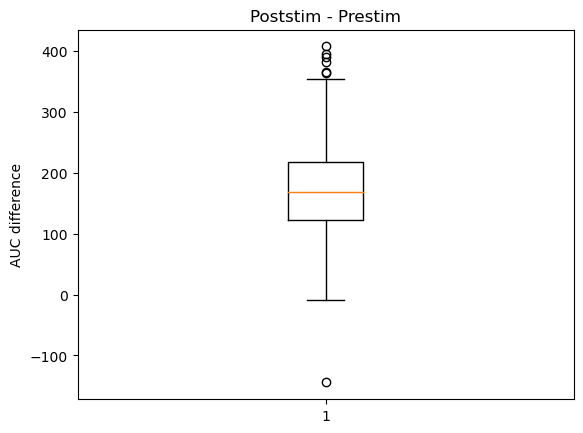

In [45]:
# Select the trials of interest:
onset_responsiveness_data =  epochs[["stimulus onset/Irrelevant", "stimulus onset/Relevant non-target"]]
# Crop the data:
prestim_data = np.squeeze(onset_responsiveness_data.copy().crop(tmin=-0.3, tmax=0).get_data(picks='LO1'))
poststim_data = np.squeeze(onset_responsiveness_data.copy().crop(tmin=0.05, tmax=0.350).get_data(picks='LO1'))
# Compute the AUC:
prestim_auc = np.trapz(prestim_data, axis=1)
poststim_auc = np.trapz(poststim_data, axis=1)
# Perform a two sided paired t-test:
results = scipy.stats.ttest_rel(prestim_auc, poststim_auc, axis=0, nan_policy='propagate',
                                alternative='two-sided')
print('T-test results:')
print('   T-stat={}'.format(results.statistic))
print('   p-value={}'.format(results.pvalue))
print('   df={}'.format(results.df))
fig, ax = plt.subplots()
ax.boxplot(poststim_auc - prestim_auc)
ax.set_title('Poststim - Prestim')
ax.set_ylabel('AUC difference')

### Onset responsiveness pipeline
The above example was applied to a single channel from a single participant. We further provide pipelines that enable the 
computation of onset responsiveness on all channels and subjects. As in the case of the preprocessing pipeline, this can
be achieved by calling the function onset_responsiveness which takes 3 mandatory inputs:
- config_file: a json file specifying the details of the analysis, such as the trials on which to apply the pipeline, pre and post stimuli time windows, metric to use...
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.
Just as in the case of the pre-processing, the config files are highly configurable with many additional options. Make sure to visit XXX to investigate these options and how to specify them.

This function further takes two additional inputs:
- plot_single_channels: boolean flag to plot single electrodes or not
- plot_only_responsive: boolean flag to plot only those channels that were found to have differences in activation compared to baseline. 

Single channels plotting can take a long time, so you might want to deactivate it.

In [46]:
subjects_list = ["SF102"]
config_file = "pipelines/onset_responsiveness_config-default.json"
results = onset_responsiveness(config_file, subjects_list, bids_root,
                                   plot_single_channels=False, plot_only_responsive=False)

----------------------------------------
Welcome to Onset Responsiveness!
The onset responsive channels of the following subjects will be determined: 
['SF102']
Using the config file:
OnsetResponsiveness_task-Duration_release.json
If you have the plotting options on, it will take some time!
----------------------------------------
Onset responsiveness SF102 with config file OnsetResponsiveness_task-Duration_release.json
Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated


### Investigate the results
Now that we have ran the onset responsiveness analysis, we can provide some summary statistics for the 
data. 

----------------------------------------
46 out of 92 (50.0%) were found to be onset responsive!


<Axes: xlabel='reject'>

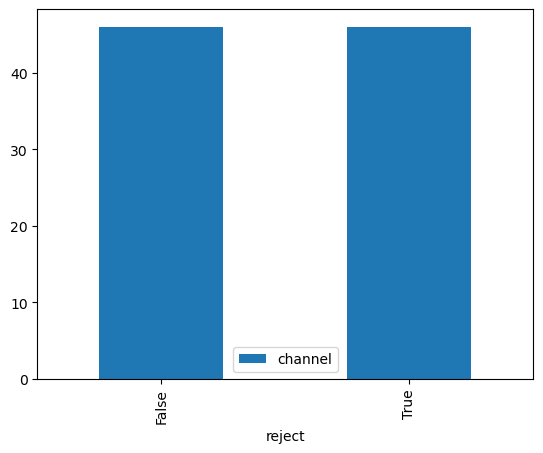

In [47]:
# Channels counts:
channels_counts = results.groupby("reject").count().reset_index()[["reject", "channel"]]
# Print the counts:
print('-'*40)
print("{} out of {} ({}%) were found to be onset responsive!".format(
    channels_counts.loc[channels_counts['reject'] == True, 'channel'].item(), len(results),
    channels_counts.loc[channels_counts['reject'] == True, 'channel'].item() / len(results) * 100))
# Plot the results as a bar graph:
channels_counts.plot.bar(x="reject", y="channel")


We can also further investigate the results by looking at each subject separately:

  subject  reject  channel
0   SF102   False       46
1   SF102    True       46


<Axes: >

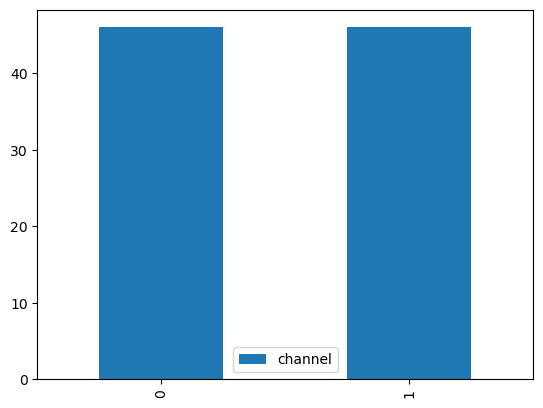

In [48]:
subjects_channels_counts = results.groupby(["subject", "reject"]).count().reset_index()[["subject", "reject", "channel"]]
# Print the counts:
print(subjects_channels_counts)
# Plot the results as a bar graph:
subjects_channels_counts.plot.bar()

### Plotting responsive channels on the brain surface
One important sanity check is to make sure that the localization of the effects make sense. As 
the task in the COGITATE was visual, one would expect to find a lot of onset responsive electrodes
over the posterior cortex. To check whether that is the case, we will extract only the onset responsive
electrodes that we hve identified above and we will plot that on the pial surface. 

This step require MNE setup to have been performed as to allow 3D rendering. Consult the MNE webpage: XXX

In [49]:
# Extract the onset responsive electrodes:
onset_responsive_results = results.loc[results["reject"] == True]
# Get these channels localization in MNI space:
mni_info = get_channels_mni_coordinates(onset_responsive_results["channel"].to_list(), 
                                                       bids_path, Path(bids_path.root, 'derivatives', 'fs'))

# We can now go ahead and plot the dig montage on the brain:
fig = plot_alignment(
    info=mni_info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=Path(bids_path.root, 'derivatives', 'fs'),
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=(1.0, 1.0, 1.0, 0.5),
)
mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, mni_info)


NameError: name 'get_channels_mni_coordinates' is not defined

Additionally, not only do we expect more channels to be responsive in posterior regions, we also expect the effects to be stronger. To vizualize this, you can plot the effect sizes of the onset
responsiveness on the brain.

In [ ]:
# Extract the effect sizes:
f_sizes = onset_responsive_results["f_size"].to_list()
# Normalized to be between 0 and 1
min_f = min(f_sizes)
max_f = max(f_sizes)
f_sizes_norm = [(x - min_f) / (min_f - min_f) for x in f_sizes]
# Get cb
rgba = colormaps.get_cmap("RdYlBu_r")
# Extract RGB for effect sizes:
sensor_colors = np.array([rgba(val) for val in f_sizes_norm])
# We can now go ahead and plot the dig montage on the brain:
fig = plot_alignment(
    info=mni_info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=Path(bids_path.root, 'derivatives', 'fs'),
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=sensor_colors,
)
mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, mni_info)

### Investigate specific regions of interest
We further provide functionalities to extract channels located in specific regions of interest. This will be illustrated by extracting channels located within the visual cortex. We will extract all channels located within the G_cuneus, G_occipital_sup, G_occipital_sup, Pole_occipital, S_calcarine, S_oc_sup_and_transversal, S_oc_middle_and_Lunatus as defined by the Destrieux atlas.

The following channels were found in the ROI
['LO1', 'LO2']


<Axes: xlabel='reject'>

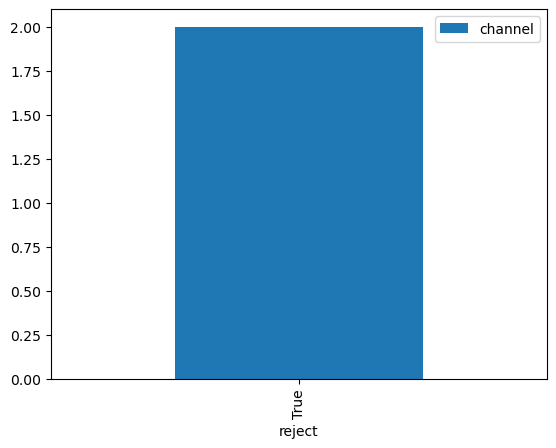

In [50]:
# Define the list of regions of interest:
rois = ["G_cuneus", "G_occipital_sup", "G_occipital_sup", "Pole_occipital", "S_calcarine", 
        "S_oc_sup_and_transversal", "S_oc_middle_and_Lunatus"]
# Extract the channels within this ROI:
roi_channels = get_roi_channels(epochs.ch_names, rois, bids_path, 'aparc.a2009s+aseg')
print('The following channels were found in the ROI')
print(roi_channels)
# Extract the onset responsiveness results for the channels only:
roi_onset_responsiveness = results.loc[results['channel'].isin(['-'.join(['SF102', channel]) for channel in roi_channels])]
channels_counts = roi_onset_responsiveness.groupby("reject").count().reset_index()[["reject", "channel"]]
# Plot the results as a bar graph:
channels_counts.plot.bar(x="reject", y="channel")

## Decoding
In addition to investigate the univariate responses of every single channel, we can also performed a multivariate analysis, investigating the presence of representation of particular contrasts of interests across the electrodes in our sample. In the current example, we will
use support vector machine to decode faces vs. objects across all electrodes within our example subject.

We will perform temporal generalization decoding using support vector machine for the faces vs objects labels in the task irrelevant trials. We will first prepare the data by selecting only seeg and ecog channels, downsample the data and select the conditions of interest. We will then create a classifier and apply it to our data with 5 fold cross validation and score the decoding accuracy using roc_auc. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


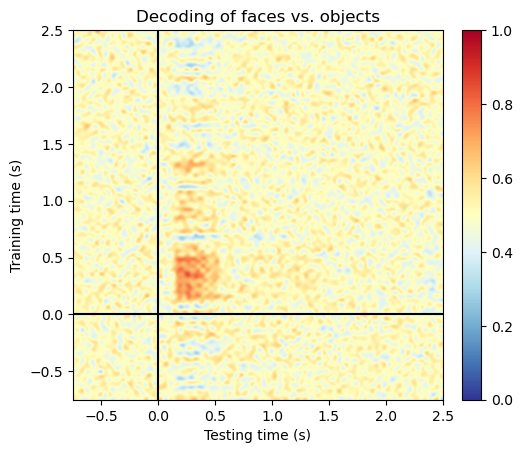

In [51]:
# Import the required libraries:
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from mne.decoding import (GeneralizingEstimator, cross_val_multiscore)


#Select electrodes:
picks = mne.pick_types(epochs.info, ecog=True, seeg=True)
decoding_epochs = epochs.copy().pick(picks)
# Downsample:
decoding_epochs.resample(30, n_jobs=1)
# Select trials:
decoding_epochs = decoding_epochs[["stimulus onset/Irrelevant/face", "stimulus onset/Irrelevant/object"]]

# Create the classifier:
clf_steps = []
clf_steps.append(StandardScaler())
clf_steps.append(svm.SVC(kernel='linear', class_weight='balanced'))
clf = make_pipeline(*clf_steps)
# Temporal generalization estimator:
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose="ERROR")

# Extract the data:
data = decoding_epochs.get_data()
# Get the classes:
y = decoding_epochs.metadata["category"].values
# Run the decoding:
scores = cross_val_multiscore(time_gen, data, y, cv=5, n_jobs=None)

# Plot the results:
fig, ax = plt.subplots()
# Plot matrix with transparency:
im = ax.imshow(np.mean(scores, axis=0), cmap="RdYlBu_r",
               extent=[epochs.times[0], epochs.times[-1], epochs.times[0], epochs.times[-1]],
               origin="lower",  # aspect="equal",
               interpolation="lanczos", vmin=0, vmax=1)
# Add the axis labels and so on:
ax.set_xlim([epochs.times[0], epochs.times[-1]])
ax.set_ylim([epochs.times[0], epochs.times[-1]])
ax.set_xlabel("Testing time (s)")
ax.set_ylabel("Training time (s)")
ax.set_title("Decoding of {}".format("faces vs. objects"))
ax.axvline(0, color='k')
ax.axhline(0, color='k')
fig.colorbar(im, fraction=0.046, pad=0.04)

### Decoding pipeline
The above example was applied to a single participant. We further provide pipelines to perform decoding on all subjects. This can be achieved by calling the function decoding which takes 3 mandatory inputs:

- config_file: a json file specifying the details of the analysis, such as trials to select, decoding targets, cross task generalization...
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive. Just as in the case of the pre-processing, the config files are highly configurable with many additional options. Make sure to visit XXX to investigate these options and how to specify them.


In [52]:
subjects_list = ["SF102"]
config_file = "pipelines/decoding_config-default.json"
scores = decoding(config_file, subjects_list, bids_root)

----------------------------------------
Welcome to Decoding!
The onset responsive channels of the following subjects will be determined: 
['SF102']
Using the config file:
Decoding_task-Duration_release.json
----------------------------------------
Decoding SF102 with config file Decoding_task-Duration_release.json
Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated
Decoding category with 5 folds stratified cross validation:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.2s finished


### Decoding within regions of interest
In the case of decoding, it is especially relevant to be able to investigate spatial specificy. This can be achieved as shown in the onset responsiveness analysis by pre-selecting channels based on their anatomical labels. We will here show how to do so by selecting channels located within a posterior ROI defined by the following labels:



The following channels were found in the ROI
['G1', 'G2', 'G3', 'G4', 'G5', 'G9', 'G10', 'G11', 'G17', 'G18', 'G19', 'G25', 'G26', 'LF5', 'LF6', 'LPF4', 'LPF5', 'LPF6', 'G34', 'DLAI3', 'DLAI4']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


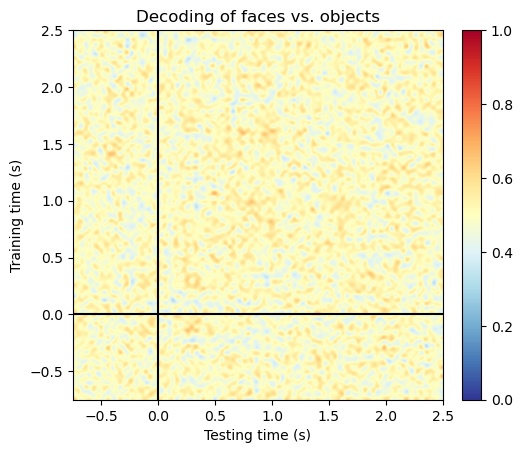

In [54]:
rois = ["G_front_inf-Triangul", "S_front_sup", "S_front_middle", "G_front_middle", "S_front_inf", 
        "Lat_Fis-ant-Vertical", "G_front_inf-Opercular", "S_precentral-inf-part"]
# Extract the channels within this ROI:
roi_channels = get_roi_channels(epochs.ch_names, rois, bids_path, 'aparc.a2009s+aseg')
print('The following channels were found in the ROI')
print(roi_channels)

# Selecting those channels only:
roi_epochs = epochs.copy().pick(roi_channels)
# Downsample:
roi_epochs.resample(30, n_jobs=1)
# Select trials:
roi_epochs = roi_epochs[["stimulus onset/Irrelevant/face", "stimulus onset/Irrelevant/object"]]

# Create the classifier:
clf_steps = []
clf_steps.append(StandardScaler())
clf_steps.append(svm.SVC(kernel='linear', class_weight='balanced'))
clf = make_pipeline(*clf_steps)
# Temporal generalization estimator:
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose="ERROR")

# Extract the data:
data = roi_epochs.get_data()
# Get the classes:
y = roi_epochs.metadata["category"].values
# Run the decoding:
scores = cross_val_multiscore(time_gen, data, y, cv=5, n_jobs=None)

# Plot the results:
fig, ax = plt.subplots()
# Plot matrix with transparency:
im = ax.imshow(np.mean(scores, axis=0), cmap="RdYlBu_r",
               extent=[epochs.times[0], epochs.times[-1], epochs.times[0], epochs.times[-1]],
               origin="lower",  # aspect="equal",
               interpolation="lanczos", vmin=0, vmax=1)
# Add the axis labels and so on:
ax.set_xlim([epochs.times[0], epochs.times[-1]])
ax.set_ylim([epochs.times[0], epochs.times[-1]])
ax.set_xlabel("Testing time (s)")
ax.set_ylabel("Training time (s)")
ax.set_title("Decoding of {}".format("faces vs. objects"))
ax.axvline(0, color='k')
ax.axhline(0, color='k')
fig.colorbar(im, fraction=0.046, pad=0.04)